In [1]:
!python -m pip uninstall kernel_go_brrrrr -y
!python setup.py install

running install
running bdist_egg
running egg_info
writing kernel_go_brrrrr.egg-info\PKG-INFO
writing dependency_links to kernel_go_brrrrr.egg-info\dependency_links.txt
writing top-level names to kernel_go_brrrrr.egg-info\top_level.txt
reading manifest file 'kernel_go_brrrrr.egg-info\SOURCES.txt'
writing manifest file 'kernel_go_brrrrr.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_ext
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\kernel_go_brrrrr
copying build\lib.win-amd64-cpython-310\kernel_go_brrrrr\Dot.cp310-win_amd64.pyd -> build\bdist.win-amd64\egg\kernel_go_brrrrr
copying build\lib.win-amd64-cpython-310\kernel_go_brrrrr\Dot1.cp310-win_amd64.pyd -> build\bdist.win-amd64\egg\kernel_go_brrrrr
copying build\lib.win-amd64-cpython-310\kernel_go_brrrrr\Dot2.cp310-win_amd64.pyd -> build\bdist.win-amd64\egg\kernel_go_brrrrr
copying build\lib.win-amd64-cpython-310\kernel_go_brrrrr\Dot3.cp310-win_amd64.p

c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ******************

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Defined in setup.py
import kernel_go_brrrrr

c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\gabri\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 1 - Garbage dot product

We will start by doing a basic dot product with one thread. Yes this will be terrible.

In [3]:
from kernel_go_brrrrr import Dot1

In [4]:
# Let's do a small dot product
N = 128
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Outputs should be the same
out = A@B
out2 = Dot1.float32(A, B)
print(torch.allclose(out, out2))

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)

True


27.6 µs ± 982 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
40.9 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Wow not that bad

In [5]:
# Let's do a small dot product
N = 12800
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)

26.6 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
544 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Ha just kidding this thing sucks :)

# 2 - Global memory is large, but slow :/
Global memory is called HBM - high bandwidth memory
- On an A100, we have 40 GB or 80 GB. Really high. This is where tensors are "stored"

Problem: doing anything with HBM is slow

Solution: we should utilize small "thread" memory called SRAM
- On an A100, SRAM is like 20 MB or something

In [6]:
from kernel_go_brrrrr import Dot1, Dot2

In [7]:
# Small dot product
N = 128
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Outputs should be the same
out = A@B
out2 = Dot1.float32(A, B)
out3 = Dot2.float32(A, B)
print(torch.allclose(out, out2))
print(torch.allclose(out, out2))

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)

True
True


28 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
41.3 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
34.5 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
# Large dot product
N = 12800
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)

26.5 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
543 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
188 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Wow, massive improvement, but still sucks. Fortunately, we are not utilizing cuda.

# 3 - Multiple Threads - Actually Utilizing Cuda
Intead of using one thread, we can have each thread compute the product of individual items in the vector.

For example, let's say we have vectors A = [1,2,3] and B = [4,5,6]

We will utilize three threads which will compute the following in parallel. Note that each thread stores the result in "shared SRAM memory":
- T1: shared[0] = 1 * 4
- T2: shared[1] = 2 * 5
- T3: shared[2] = 3 * 6

We now have shared memory that look like:
[4, 10, 18]

Now we need to sum these. An inefficient, but easy way to do this is by summing all elements with thread 1. Then stores this in the result.

In [9]:
from kernel_go_brrrrr import Dot1, Dot2, Dot3

In [10]:
# Small dot product
N = 128
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Outputs should be the same
out = A@B
out2 = Dot1.float32(A, B)
out3 = Dot2.float32(A, B)
out4 = Dot3.float32(A, B)
print(torch.allclose(out, out2))
print(torch.allclose(out, out2))
print(torch.allclose(out, out3))
print(torch.allclose(out, out4))

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)
%timeit Dot3.float32(A, B)

True
True
True
True


30 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
79.4 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
34.4 µs ± 1.65 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
34.5 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
# Large dot product
N = 1024
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

out = A@B
out2 = Dot1.float32(A, B)
out3 = Dot2.float32(A, B)
out4 = Dot3.float32(A, B)
print(torch.allclose(out, out2))
print(torch.allclose(out, out2))
print(torch.allclose(out, out3))
print(torch.allclose(out, out4))

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)
%timeit Dot3.float32(A, B)

True
True
True
True


25.3 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
68.6 µs ± 3.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
42.7 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.2 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We have a problem

When doing the sum, only thread 1 is doing work. Can we make this better? Yes... yes we can.

Another problem occurs when we go beyond a dimension size of 1024. This is because the max number of threads is 1024. The code currently assumes each thread gets one elemnts, however in the case of the vector size being larger than 1024, each thread must get more than one element. I do not feel like dealing with this so cry about it.

If you've cried about it and want to cope, then you can have each thread do num_elements//num_threads work instead of just 1 operation.

# 4 - Utilizing warps and making a tree

A "warp" is a special thing in cuda which allows for super efficient operations called "warp level primitives" which are really fast operations that can be performed in a warp.

On all Nvidia GPUs the "warp" size is 32.

This means we can utilize warp level primitives on 32 threads.

One such primitive is a sum reduction. We can utilize this primitive to do a sum between 32 threads. This looks quite useful for our task :)

We also want to utilize all threads as much as possible. To do this, we will create a binary tree as follows:
         
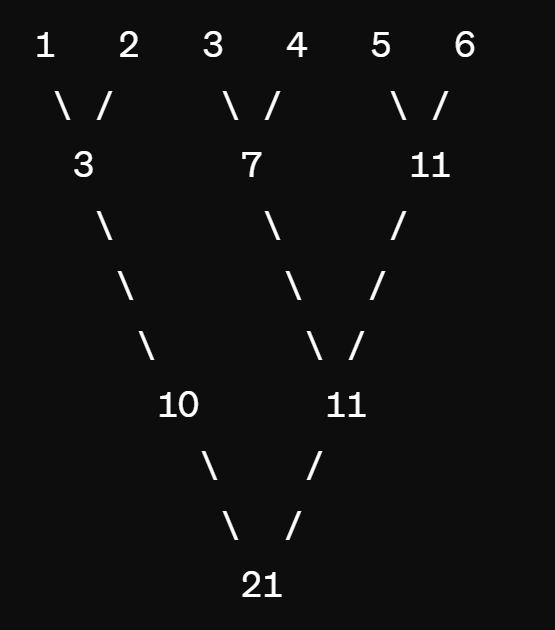

This utilizes parallelism much better.

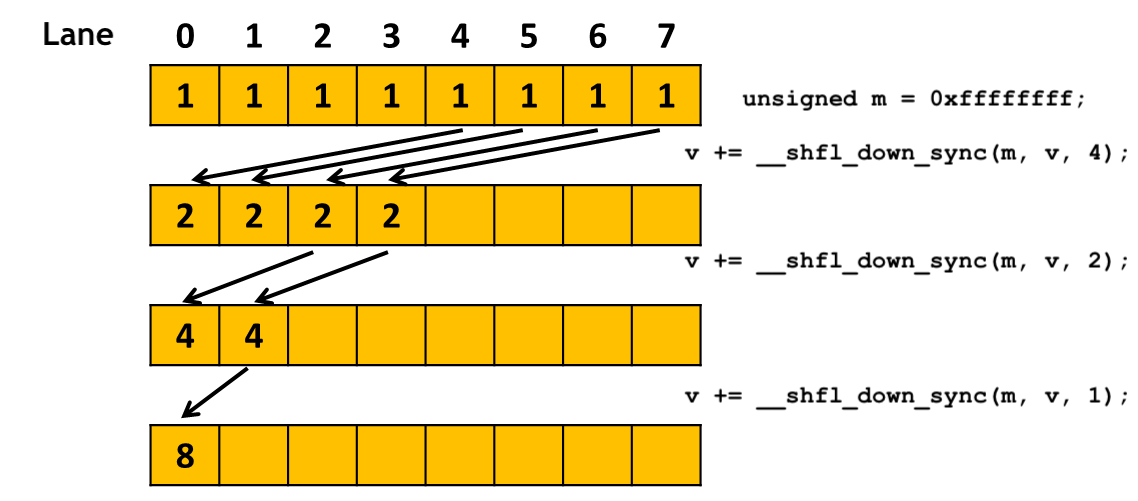

In [12]:
from kernel_go_brrrrr import Dot1, Dot2, Dot3, Dot4

In [13]:
# Small dot product
N = 64
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Outputs should be the same
out = A@B
out2 = Dot1.float32(A, B)
out3 = Dot2.float32(A, B)
out4 = Dot3.float32(A, B)
out5 = Dot4.float32(A, B)
print(torch.allclose(out, out2))
print(torch.allclose(out, out2))
print(torch.allclose(out, out3))
print(torch.allclose(out, out4))
print(torch.allclose(out, out5))

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)
%timeit Dot3.float32(A, B)
%timeit Dot4.float32(A, B)

True
True
True
True
True


23.2 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.6 µs ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.5 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.3 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.6 µs ± 992 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
# Large dot product
N = 1024
A = torch.randn(N).cuda()
B = torch.randn(N).cuda()

# Time each operation
%timeit A@B
%timeit Dot1.float32(A, B)
%timeit Dot2.float32(A, B)
%timeit Dot3.float32(A, B)
%timeit Dot4.float32(A, B)

27.7 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
63.4 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
44.3 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
36 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.6 µs ± 725 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# 5 - Matrix Multiplication

Let's do a basic matrix multiplication between an Nxd and Mxd matrix.

In [15]:
from kernel_go_brrrrr import Matmul1

In [16]:
N = 128
M = 256
d = 64

A = torch.randn(N, d).cuda()
B = torch.randn(M, d).cuda()

out = A@B.T
out2 = Matmul1.float32(A, B)

# Outputs should be the same
print(torch.allclose(out, out2))

# Time each operation
%timeit A@B.T
%timeit Matmul1.float32(A, B)

True


19.7 µs ± 500 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
20 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 6 - Parallelizing the matmul
first idea may be to have d threads which will do the dot product, like we did before.

In [17]:
from kernel_go_brrrrr import Matmul1, Matmul2

In [18]:
N = 128
M = 256
d = 128

A = torch.randn(N, d).cuda()
B = torch.randn(M, d).cuda()

out = A@B.T
out2 = Matmul1.float32(A, B)
out3 = Matmul2.float32(A, B)

# Outputs should be the same
print(torch.allclose(out, out2, 3))
print(torch.allclose(out, out3, 3))

# Time each operation
%timeit A@B.T
%timeit Matmul1.float32(A, B)
%timeit Matmul2.float32(A, B)

True
True


19.8 µs ± 429 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
73.5 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.7 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


this still sucks

# 7 - Tiling

So what's the problem?
- We do not have enough threads to do all computations at once
- So, we must breakup the computation into groups which will be computed by all the threads at our disposal.

We will finally utilize blocks. The idea is that we can "tile" the output matrix and do computations over a sliding window.

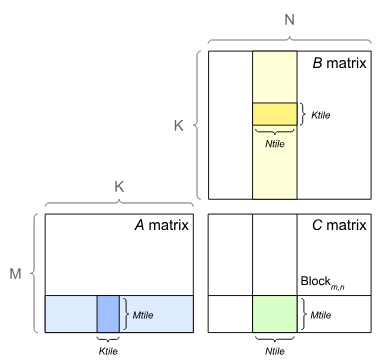

In [19]:
from kernel_go_brrrrr import Matmul1, Matmul2, Matmul3

In [20]:
N = 128
M = 256
d = 128

A = torch.randn(N, d).cuda()
B = torch.randn(M, d).cuda()

out = A@B.T
out2 = Matmul1.float32(A, B)
out3 = Matmul2.float32(A, B)
out4 = Matmul3.float32(A, B)

# Outputs should be the same
print(torch.allclose(out, out2, 3))
print(torch.allclose(out, out3, 3))
print(torch.allclose(out, out4, 3))

# Time each operation
%timeit A@B.T
%timeit Matmul1.float32(A, B)
%timeit Matmul2.float32(A, B)
%timeit Matmul3.float32(A, B)

True
True
True


70.9 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
78.4 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.4 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
191 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# 8 - Preload data

We can also preload the data into a cache with all the threads before doing the computiong. In this case, it doesn't do much, but in same cases it can be better.

In [21]:
from kernel_go_brrrrr import Matmul1, Matmul2, Matmul3, Matmul4

In [26]:
N = 128
M = 256
d = 128

A = torch.randn(N, d).cuda()
B = torch.randn(M, d).cuda()

out = A@B.T
out2 = Matmul1.float32(A, B)
out3 = Matmul2.float32(A, B)
out4 = Matmul3.float32(A, B)
out5 = Matmul4.float32(A, B)

# Outputs should be the same
print(torch.allclose(out, out2, 3))
print(torch.allclose(out, out3, 3))
print(torch.allclose(out, out4, 3))
print(torch.allclose(out, out5, 3))

# Time each operation
%timeit A@B.T
%timeit Matmul1.float32(A, B)
%timeit Matmul2.float32(A, B)
%timeit Matmul3.float32(A, B)
%timeit Matmul4.float32(A, B)

True
True
True
True
26.9 µs ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
78.2 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.5 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
215 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
219 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
N = 128
M = 256
d = 128

A = torch.randn(N, d).cuda().to(torch.float16)
B = torch.randn(M, d).cuda().to(torch.float16)

out = A@B.T
out2 = Matmul1.float16(A, B)
out3 = Matmul2.float16(A, B)
out4 = Matmul3.float16(A, B)
out5 = Matmul4.float16(A, B)

# Time each operation
%timeit A@B.T
%timeit Matmul1.float16(A, B)
%timeit Matmul2.float16(A, B)
%timeit Matmul3.float16(A, B)
%timeit Matmul4.float16(A, B)

21.4 µs ± 955 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
96.7 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.1 ms ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
284 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
300 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
